# Feature & Classifier Exploration

Exploratory analysis of CNN features and classifier behavior.

Models compared:
- Decision Tree
- Logistic Regression
- Support Vector Machine (SVM)

In [12]:
import os, sys, cv2
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

sys.path.append(os.path.abspath('..'))
from src.feature_extractor import extract_features

## Load Dataset and Extract Features

In [13]:
DATASET_DIR = '../dataset'
CATEGORIES = {'with_mask': 1, 'without_mask': 0}

X, y = [], []
for category, label in CATEGORIES.items():
    folder = os.path.join(DATASET_DIR, category)
    for fname in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, fname))
        if img is None: continue
        X.append(extract_features(img))
        y.append(label)

X = np.array(X)
y = np.array(y)
print('Total samples:', X.shape[0])
print('Feature vector length:', X.shape[1])

Total samples: 500
Feature vector length: 1922


## PCA Projection

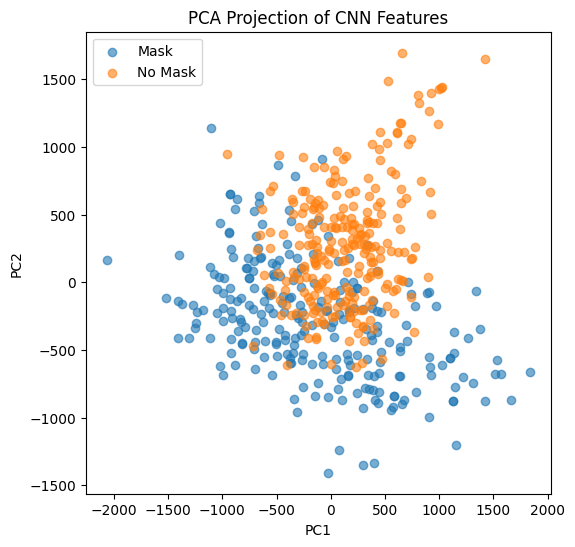

In [14]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(6,6))
plt.scatter(X_pca[y==1,0], X_pca[y==1,1], label='Mask', alpha=0.6)
plt.scatter(X_pca[y==0,0], X_pca[y==0,1], label='No Mask', alpha=0.6)
plt.legend(); plt.xlabel('PC1'); plt.ylabel('PC2')
plt.title('PCA Projection of CNN Features'); plt.show()

## Train-Test Split

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)
Xp_train, Xp_test, yp_train, yp_test = train_test_split(
    X_pca, y, test_size=0.2, random_state=42, stratify=y)

## Accuracy Comparison

In [16]:
dt = DecisionTreeClassifier(max_depth=5, random_state=42)
dt.fit(X_train, y_train)
acc_dt = accuracy_score(y_test, dt.predict(X_test))

lr = Pipeline([('scaler', StandardScaler()),
               ('lr', LogisticRegression(max_iter=1000))])
lr.fit(X_train, y_train)
acc_lr = accuracy_score(y_test, lr.predict(X_test))

svm = Pipeline([('scaler', StandardScaler()),
                ('svm', SVC(kernel='rbf', gamma='scale'))])
svm.fit(X_train, y_train)
acc_svm = accuracy_score(y_test, svm.predict(X_test))

print('Decision Tree:', acc_dt)
print('Logistic Regression:', acc_lr)
print('SVM:', acc_svm)

Decision Tree: 0.78
Logistic Regression: 0.93
SVM: 0.92


## Decision Tree (PCA Space)

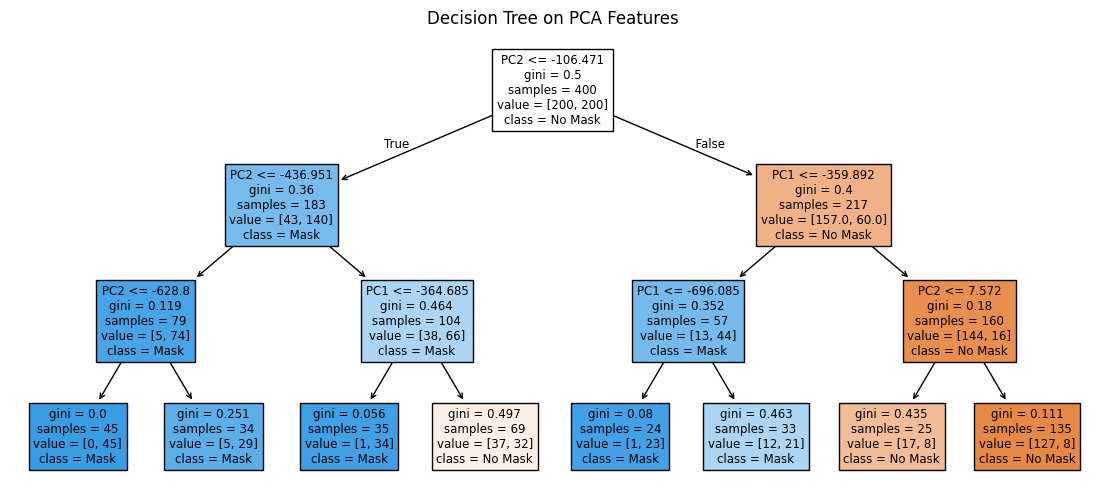

In [17]:
dt_pca = DecisionTreeClassifier(max_depth=3, random_state=42)
dt_pca.fit(Xp_train, yp_train)

plt.figure(figsize=(14,6))
plot_tree(dt_pca, feature_names=['PC1','PC2'],
          class_names=['No Mask','Mask'], filled=True)
plt.title('Decision Tree on PCA Features'); plt.show()

## Logistic Regression Boundary (PCA Space)

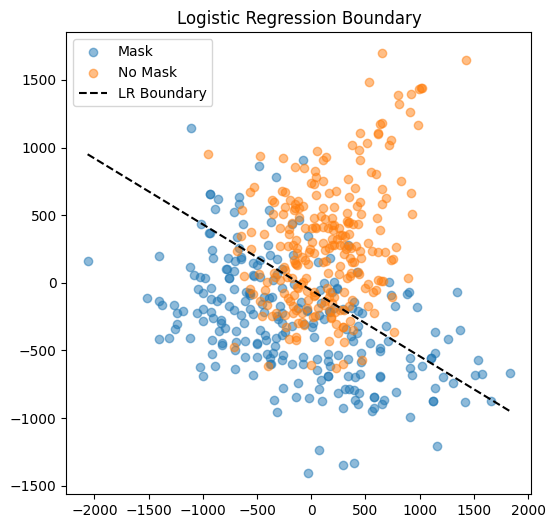

In [18]:
lr_pca = LogisticRegression()
lr_pca.fit(Xp_train, yp_train)

w = lr_pca.coef_[0]; b = lr_pca.intercept_[0]
x_vals = np.linspace(X_pca[:,0].min(), X_pca[:,0].max(), 200)
y_vals = -(w[0]*x_vals + b)/w[1]

plt.figure(figsize=(6,6))
plt.scatter(X_pca[y==1,0], X_pca[y==1,1], label='Mask', alpha=0.5)
plt.scatter(X_pca[y==0,0], X_pca[y==0,1], label='No Mask', alpha=0.5)
plt.plot(x_vals, y_vals, 'k--', label='LR Boundary')
plt.legend(); plt.title('Logistic Regression Boundary'); plt.show()

## SVM Decision Regions (PCA Space)

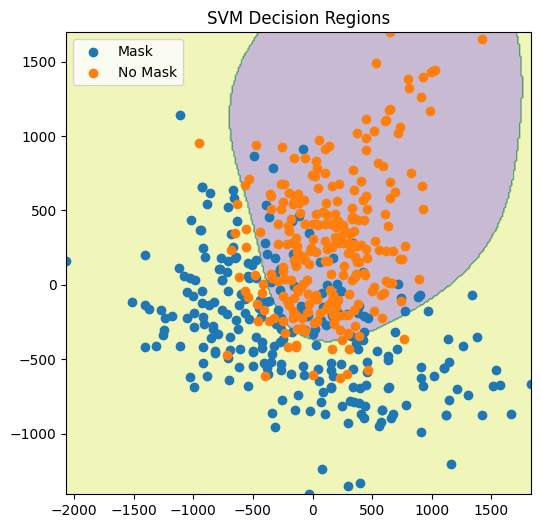

In [19]:
svm_pca = SVC(kernel='rbf', gamma='scale')
svm_pca.fit(Xp_train, yp_train)

xx, yy = np.meshgrid(
    np.linspace(X_pca[:,0].min(), X_pca[:,0].max(), 300),
    np.linspace(X_pca[:,1].min(), X_pca[:,1].max(), 300))

Z = svm_pca.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.figure(figsize=(6,6))
plt.contourf(xx, yy, Z, alpha=0.3)
plt.scatter(X_pca[y==1,0], X_pca[y==1,1], label='Mask')
plt.scatter(X_pca[y==0,0], X_pca[y==0,1], label='No Mask')
plt.legend(); plt.title('SVM Decision Regions'); plt.show()

## Conclusion

Decision Trees show unstable splits on CNN features.

Logistic Regression performs well but assumes linear separability.

**SVM provides the most robust decision boundary** and is chosen
for the final system.